In [2]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM

In [3]:
CHANNEL = "A-3"

In [4]:
class Channel:
    def __init__(self, chan_id):
        self.id = chan_id
        self.train = None
        self.test = None
        self.l_s = 250
        self.n_predictions = 10
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.y_hat = None

    def shape_data(self, arr, training=True):
        data = []
        for i in range(len(arr) - self.l_s - self.n_predictions):
            data.append(arr[i: i + self.l_s + self.n_predictions])
            
        data = np.array(data)

        if training:
            np.random.shuffle(data)
            self.X_train = data[:, :-self.n_predictions, :]
            self.y_train = data[:, -self.n_predictions:, 0]
        else:
            self.X_test = data[:, :-self.n_predictions, :]
            self.y_test = data[:, -self.n_predictions:, 0]

    def load_data(self):
        try:
            self.train = np.load(os.path.join("data", "train", "{}.npy".format(self.id)))
            self.test = np.load(os.path.join("data", "test", "{}.npy".format(self.id)))
        except FileNotFoundError as e:
            print(e)

        self.shape_data(self.train)
        self.shape_data(self.test, training=False)

In [5]:
new_channel = Channel(CHANNEL)
new_channel.load_data()

In [6]:
new_channel.X_train.shape[2]

25

In [7]:
new_channel.test.shape

(8205, 25)

In [8]:
new_channel.test.shape
new_channel.X_test.shape
new_channel.X_test.shape

(7945, 250, 25)

In [9]:
new_channel.train

array([[0.11308108, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.11308108, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.3336605 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.76415679, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.76415679, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.76415679, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [11]:
class Model:
    def __init__(self, channel):
        self.chan_id = channel.id
        self.y_hat = np.array([])
        self.model = None
        self.train_new(channel)
        

    def train_new(self, channel):
        cbs = [History(), EarlyStopping(monitor='val_loss',
                                        patience=10,
                                        min_delta=0.0003,
                                        verbose=0)]

        self.model = Sequential()

        self.model.add(LSTM(
            80,
            input_shape=(None, channel.X_train.shape[2]),
            return_sequences=True))
        self.model.add(Dropout(0.3))

        self.model.add(LSTM(
            80,
            return_sequences=False))
        self.model.add(Dropout(0.3))

        self.model.add(Dense(
            channel.n_predictions))
        self.model.add(Activation('linear'))

        self.model.compile(loss='mse',
                           optimizer='adam')

        self.model.fit(channel.X_train,
                       channel.y_train,
                       batch_size=64,
                       epochs=35,
                       validation_split=0.2,
                       callbacks=cbs,
                       verbose=True)
        
    def aggregate_predictions(self, y_hat_batch, method='first'):
        agg_y_hat_batch = np.array([])

        for t in range(len(y_hat_batch)):

            start_idx = t - 10
            start_idx = start_idx if start_idx >= 0 else 0

            # predictions pertaining to a specific timestep lie along diagonal
            y_hat_t = np.flipud(y_hat_batch[start_idx:t+1]).diagonal()

            if method == 'first':
                agg_y_hat_batch = np.append(agg_y_hat_batch, [y_hat_t[0]])
            elif method == 'mean':
                agg_y_hat_batch = np.append(agg_y_hat_batch, np.mean(y_hat_t))

        agg_y_hat_batch = agg_y_hat_batch.reshape(len(agg_y_hat_batch), 1)
        self.y_hat = np.append(self.y_hat, agg_y_hat_batch)
              
    def batch_predict(self, channel):
        num_batches = int((channel.y_test.shape[0] - 250)
                          / 70)

        for i in range(0, num_batches + 1):
            prior_idx = i * 70
            idx = (i + 1) * 70

            if i + 1 == num_batches + 1:
                idx = channel.y_test.shape[0]

            X_test_batch = channel.X_test[prior_idx:idx]
            y_hat_batch = self.model.predict(X_test_batch)
            self.aggregate_predictions(y_hat_batch)

        self.y_hat = np.reshape(self.y_hat, (self.y_hat.size,))

        channel.y_hat = self.y_hat

        return channel


In [44]:
model = Model(new_channel)

Epoch 1/35


2024-03-12 10:57:17.087249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-12 10:57:17.651945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-12 10:57:20.935126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-12 10:57:24.189848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-12 10:58:06.192652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - ETA: 0s - loss: 0.1089

2024-03-12 11:00:26.486702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-12 11:00:26.659136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-12 11:00:29.585495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 205s 4s/step - loss: 0.1089 - val_loss: 0.0354
Epoch 2/35
31/31 [==============================] - 11s 367ms/step - loss: 0.0365 - val_loss: 0.0308
Epoch 3/35
31/31 [==============================] - 10s 313ms/step - loss: 0.0326 - val_loss: 0.0299
Epoch 4/35
31/31 [==============================] - 9s 295ms/step - loss: 0.0315 - val_loss: 0.0291
Epoch 5/35
31/31 [==============================] - 9s 299ms/step - loss: 0.0289 - val_loss: 0.0294
Epoch 6/35
31/31 [==============================] - 9s 291ms/step - loss: 0.0282 - val_loss: 0.0271
Epoch 7/35
31/31 [==============================] - 9s 281ms/step - loss: 0.0278 - val_loss: 0.0260
Epoch 8/35
31/31 [==============================] - 9s 298ms/step - loss: 0.0265 - val_loss: 0.0254
Epoch 9/35
31/31 [==============================] - 13s 429ms/step - loss: 0.0266 - val_loss: 0.0271
Epoch 10/35
31/31 [==============================] - 10s 312ms/step - loss: 0.0252 - val_loss: 0.0247
Epoch 1

In [46]:
model.batch_predict(new_channel)

2024-03-12 11:11:21.679488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-12 11:11:21.819432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-12 11:11:24.761892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [47]:
new_channel.y_hat.shape

(7945,)

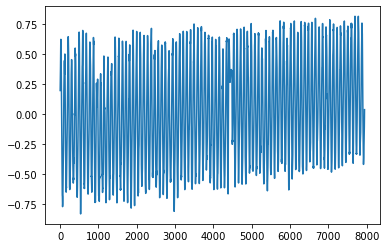

In [48]:
plt.plot(new_channel.y_hat)

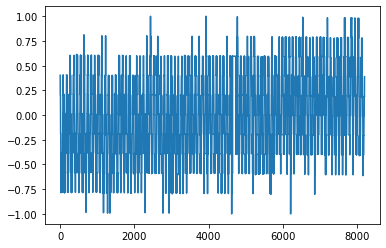

In [49]:
plt.plot(new_channel.test[:, 0])

In [106]:
class Plotter:
    def __init__(self, channel):
        self.channel = channel

    def plot_predictions(self, plot_real_data=True):
        if plot_real_data:
            plt.plot(self.channel.y_test[:, 0])
        else:
            plt.plot(self.channel.y_hat)

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()
        
    
    def plot_custom_range_predictions(self, start, end, plot_real_data=True):
        if plot_real_data:
            plt.plot([i for i in range(start, end)], self.channel.y_test[:, 0][start:end])
        else:
             plt.plot([i for i in range(start, end)], self.channel.y_hat[start:end])

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()
        
    def plot_threshold(self, error, threshold):
        plt.figure(figsize=(20,10))
        plt.plot(error)
        plt.plot([threshold for i in range(len(e_s))])

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()

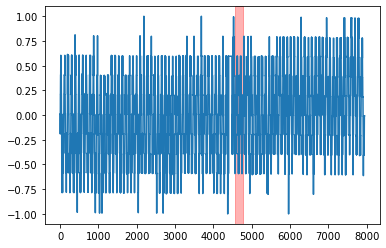

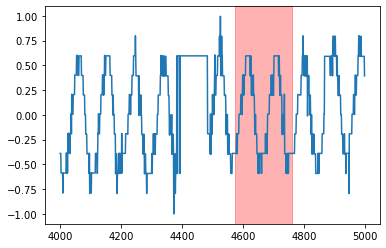

In [104]:
plotter = Plotter(new_channel)
plotter.plot_predictions()
plotter.plot_custom_range_predictions(4000, 5000)

In [52]:
error = np.abs(new_channel.y_test[:, 0] - new_channel.y_hat)
normalized = np.mean(error / np.ptp(new_channel.y_test))
normalized, error

(0.04985221865528162,
 array([0.18442339, 0.20123061, 0.21241911, ..., 0.02284934, 0.01117733,
        0.04268916]))

In [138]:
e_s = pd.DataFrame(error).ewm(span=105).mean().values.flatten()
e_s

array([0.18442339, 0.19290703, 0.19953534, ..., 0.07184755, 0.07070283,
       0.07017427])

In [174]:
import more_itertools as mit

def calculate_epsilon(e_s):
    epsilon = 0
    max_score = float('-inf')

    for i in np.arange(2, 10, 0.5):
        mean = np.mean(e_s)
        std = np.std(e_s)
        eps = mean + i*std

        delta_mean = mean - np.mean(e_s[e_s < eps])
        delta_std = std - np.std(e_s[e_s < eps])
        e_a = e_s[e_s >= eps]

        if len(e_a) > 0:
            anom = np.argwhere(e_s >= eps).reshape(-1)
            anom =[list(g) for g in mit.consecutive_groups(anom)]
            E_seq = len(anom)
            
            score = ((delta_mean/mean) + (delta_std/std)) / (E_seq**2 + len(e_a))
            if score > max_score:
                max_score = score
                epsilon = eps
    return epsilon

epsilon = calculate_epsilon(e_s)

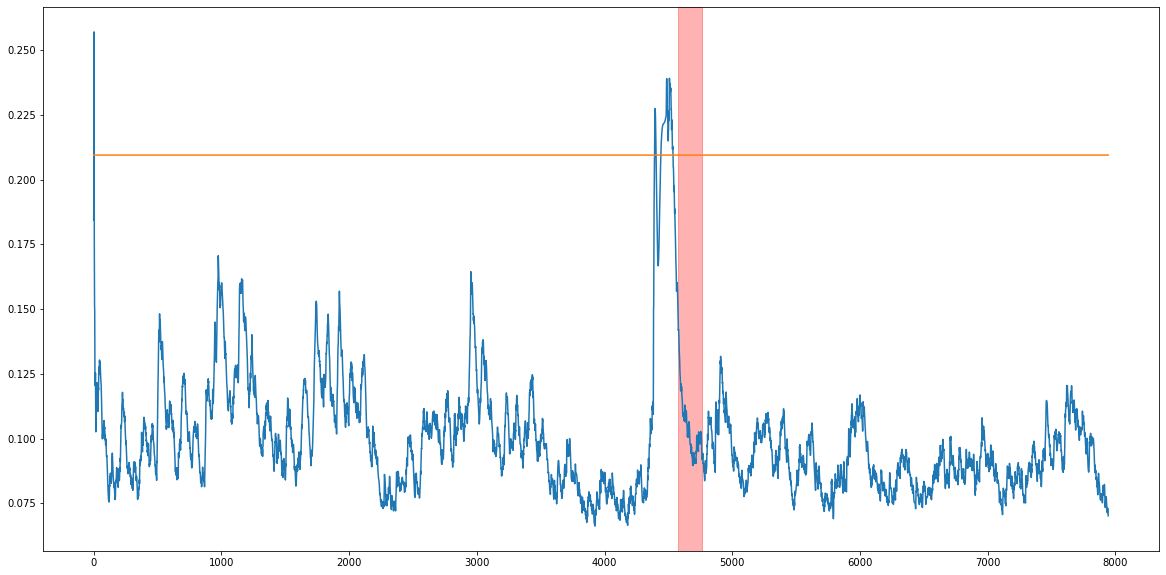

In [175]:
plotter.plot_threshold(e_s, epsilon)